In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

plt.set_cmap('gray')
scale = 2
plt.rcParams['figure.figsize'] = (2 * scale, scale)

<Figure size 640x480 with 0 Axes>

(1320, 1406)


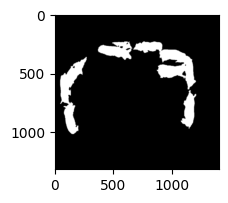

In [2]:
im = cv2.imread('pic/after_morpho.png', flags = cv2.IMREAD_GRAYSCALE)
print(im.shape)
plt.imshow(im)

# Zhang2005
### get contours

In [3]:
contours, hierarchy = cv2.findContours(im, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_NONE)
print(len(contours))

16


In [4]:
bkg = np.zeros_like(im)
new_contours = []

for i, cnt in enumerate(contours):
    area = cv2.contourArea(contour = cnt, oriented = False)
    if area < 8000:
        continue
    new_contours.append(cnt)
    print(f'{i}-th Contour area is {area}')
    M = cv2.moments(cnt)
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    print(f'Center at {(cx, cy)}')
    # draw contour
    tmp_bkg = copy.deepcopy(bkg) # cv2.drawContour, destination image
    im_cnt = cv2.drawContours(image = tmp_bkg, contours = contours, contourIdx = i, color = 127, thickness = 3)
    # plt.imshow(im_cnt)
    # plt.show()

0-th Contour area is 25351.0
Center at (1142.742331006009, 815.9270508724178)
3-th Contour area is 61655.5
Center at (132.2667510062633, 675.1580853830287)
7-th Contour area is 31779.5
Center at (529.7777602962077, 300.00640349911106)
13-th Contour area is 83001.0
Center at (984.7595792018569, 402.19946346027956)


In [5]:
# 保存
for i, cnt in enumerate(new_contours):
    np.savetxt(fname = f'data/contour/cnt{i}.txt', X = cnt.squeeze())

# Zhang2005
### fit ellipse

In [6]:
cnt = np.loadtxt(fname = 'data/contour/cnt0.txt', dtype =np.int32)[:, np.newaxis, :]
# sq_cnt_moveForward = np.delete(sq_cnt, obj = 0, axis = 0)
print(cnt.shape)

(912, 1, 2)


C:\Users\lx\AppData\Local\Temp\ipykernel_9720\2630948545.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  cnt = np.loadtxt(fname = 'data/contour/cnt0.txt', dtype =np.int32)[:, np.newaxis, :]


The boundary of this contour is from (1065, 636) to (1210, 982).


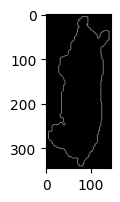

In [7]:
from show_pics import *
zoom_show_contour(im, cnt)

randomly choose 6 points from the contour

In [8]:
from Ellipse import valid_ellipse

elps_set = []
rep = 2000
for i in range(rep):
    l = len(elps_set)
    print(i + 1, l, l / (i + 1))
    selected_cols = np.random.default_rng(i).choice(cnt.shape[0], size = 6, replace = False)
    points = cnt.squeeze()[selected_cols, :]

    bkg = np.zeros_like(im, dtype = np.uint8)
    cv2.drawContours(bkg, contours = [points], contourIdx = 0, color = 127, thickness = 2)

    ellipse = cv2.fitEllipse(points)
    cv2.ellipse(bkg, ellipse, color = 127, thickness = 2) 

    # print(ellipse)

    cv2.drawContours(bkg, contours = [cnt], contourIdx = 0, color = 255, thickness = 2)    
    # zoom_show_contour(image_done = bkg, margin = 10)

    if valid_ellipse(ellipse, cnt):
        elps_set.append(ellipse)
    
        
print(f'{len(elps_set)} ellipses are collected.')

1 0 0.0
overlap ratio 0.6866810368439482=17455/25419.370950193777
2 1 0.5
overlap ratio 0.7410766117802585=18413/24846.284051209215
3 2 0.6666666666666666
4 2 0.5
5 2 0.4
6 2 0.3333333333333333
overlap ratio 0.6890251253821079=16566/24042.664613736848
7 3 0.42857142857142855
8 3 0.375
9 3 0.3333333333333333
10 3 0.3
overlap ratio 0.6980970600970865=19997/28645.013914281426
11 4 0.36363636363636365
overlap ratio 0.6408009291340955=16811/26234.35646811007
12 5 0.4166666666666667
13 5 0.38461538461538464
overlap ratio 0.659549913690472=16613/25188.38931695549
14 6 0.42857142857142855
15 6 0.4
overlap ratio 0.6998581378323626=20293/28995.876311237225
16 7 0.4375
17 7 0.4117647058823529
overlap ratio 0.7866108108186974=19313/24552.1670111541
18 8 0.4444444444444444
overlap ratio 0.7269873847187694=18905/26004.577792382577
19 9 0.47368421052631576
20 9 0.45
21 9 0.42857142857142855
22 9 0.4090909090909091
23 9 0.391304347826087
24 9 0.375
25 9 0.36
overlap ratio 0.7016738058517368=15747/2244

KeyboardInterrupt: 

In [ ]:
data = [[*e[0], *e[1], e[2]] for e in elps_set] # flatten
np.savetxt(fname = f'elps_set_i={i}.txt', X = data)

### K-means

In [9]:
data = np.loadtxt(fname = 'data/ellipse/elps_cnt0_i=417.txt')
# elps_set = list(map(lambda e: [[e[0], e[1]], [e[2], e[3]], e[4]], data))
to_cv_elps = lambda e: [[e[0], e[1]], [e[2], e[3]], e[4]]

In [10]:
def custom_distance(x1, x2):
    euclidean_distance = np.linalg.norm(x1[:-1] - x2[:-1]) # L2 norm
    angle_distance = min(abs(x1[-1] - x2[-1]), 180 - abs(x1[-1] - x2[-1]))
    return (euclidean_distance ** 2 + angle_distance ** 2) ** 0.5

from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters = 3, metric = custom_distance)
kmedoids.fit(data)
# kmedoids.labels_

KMedoids(metric=<function custom_distance at 0x00000262527FAA60>, n_clusters=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The boundary of this contour is from (1052, 578) to (1221, 1054).


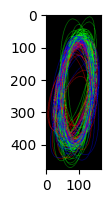

In [11]:
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [128, 128, 128], [0, 0, 0], [128, 0, 128], [255, 165, 0]]
bkg = np.zeros((*im.shape, 3))
for i, elps in enumerate(data):
    elps = to_cv_elps(elps)
    color = colors[kmedoids.labels_[i]]
    cv2.ellipse(bkg, elps, color, thickness = 1)
zoom_show_contour(image_done = bkg)
# plt.imshow(bkg)

The boundary of this contour is from (1050, 576) to (1223, 1056).


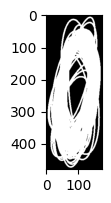

In [12]:
bkg = np.zeros_like(im, dtype = np.uint8)
for e in data:
    elps = [[e[0], e[1]], [e[2], e[3]], e[4]]
    cv2.ellipse(bkg, elps, color = 127, thickness = 3)
# _ = cv2.drawContours(bkg, contours = [cnt], contourIdx = 0, color = 255, thickness = 5)
from show_pics import zoom_show_contour
zoom_show_contour(image_done = bkg)

https://www.geeksforgeeks.org/ml-determine-the-optimal-value-of-k-in-k-means-clustering/

d:\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda3\envs\cv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_

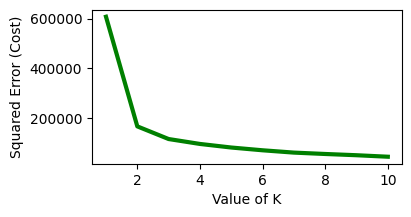

In [13]:
from sklearn.cluster import KMeans

!! feature scaling

cost = []
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(X = data)
     
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)    
 
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot
 
# the point of the elbow is the
# most optimal value for choosing k

In [14]:
# from data_generation import get_data_from_contour

In [15]:
points = get_data_from_contour(contour = cnt, draw = True, seed = 1)[:, 3:5]
print(points)
points.dtype = np.uint8
print(points)
bkg = np.zeros_like(im, dtype = np.uint8)
cv2.drawContours(bkg, contours = [points], contourIdx = 0, color = 255, thickness = 2)
plt.imshow(bkg)

NameError: name 'get_data_from_contour' is not defined

In [ ]:
tuple([1,2])

(1, 2)

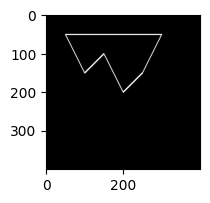

In [ ]:
# create a list of 6 points (x, y) coordinates
points = np.array([(50, 50), (100, 150), (150, 100), (200, 200), (250, 150), (300, 50)])

# create a black image with a white contour passing through the 6 points
image = np.zeros((400, 400), dtype = np.uint8)
cv2.drawContours(image, contours = [points], contourIdx = 0, color = 255, thickness = 2)
plt.imshow(image)

((174.86366271972656, -10.702613830566406), (261.1877136230469, 393.1482849121094), 174.23387145996094)


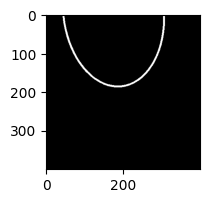

In [ ]:
# fit an ellipse to the contour using the cv2.fitEllipse() function
ellipse = cv2.fitEllipse(points)
print(ellipse)

# draw the fitted ellipse on the image
bkg_a = np.zeros_like(image)
cv2.ellipse(bkg_a, ellipse, color = 255 ,thickness = 3) 

# display the image
# cv2.imshow("Fitted Ellipse", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(bkg_a);

In [ ]:
ellipse

((174.86366271972656, -10.702613830566406),
 (261.1877136230469, 393.1482849121094),
 174.23387145996094)